In [1]:
import os

import pandas as pd

home = os.getenv("HOME") or os.getenv("USERPROFILE")
desktop = home + "/Desktop"

delays = pd.read_csv("data/traffic/delays-merged.csv")
traffic = pd.read_csv("data/weather/weather-merged.csv")
routes = pd.read_csv("data/gtfs/2025/01/03/routes.csv")

# Przygotowanie danych do analizy
## Pogoda oraz opóźnienia
Przed przystąpieniem do analizy wstępnie oczyściliśmy i znormalizowaliśmy dane. Np. w pliku `delays-merged.csv`, wartości kolumny `Delay` typu `x min` zostały podmienione na `x`, a wartości `x min przed czasem` na `-x`.
Połączyliśmy wszystki zebrane pliki z pogodą oraz opóźnieniami w pojedyncze pliki: `weather-merged.csv` oraz `delays-merged.csv`. Po połączeniu plików, zduplikowane linie zostały usunięte.
Przed przystąpieniem do agregacji danych z feedu GTFS, wpierw musimy zdecydować które dane w nim zawarte są dla nas istotne.

## GTFS
Warszawski GTFS składa się z następujących plików:
### `agency.txt`
Ten plik zawiera dane o agencjach których dotyczy feed, ma raczej charakter licencyjny. Z punktu widzenia analizy opóźnień nie jest to istotne.
### `calendar_dates.txt`
Specyfikacja tego pliku jest dość skomplikowana, tak opisuje to dokumentacja:
```
The calendar_dates.txt table explicitly activates or disables service by date. It may be used in two ways.

Recommended: Use calendar_dates.txt in conjunction with calendar.txt to define exceptions to the default service patterns defined in calendar.txt. If service is generally regular, with a few changes on explicit dates (for instance, to accommodate special event services, or a school schedule), this is a good approach. In this case calendar_dates.service_id is a foreign ID referencing calendar.service_id.
Alternate: Omit calendar.txt, and specify each date of service in calendar_dates.txt. This allows for considerable service variation and accommodates service without normal weekly schedules. In this case service_id is an ID.
```
W warszawskim feedzie nie występuje `calendar.txt`, a więc `calendar_dates.txt` opisuje "wydania" rozkładów jazdy, tj. które dane obowiązują w jakich terminach.
### `feed_info.txt`
Kolejny plik o charakterze licencyjnym, zawiera informacje o podmiocie udostępniającym feed GTFS. Nieistotny z punktu widzenia analizy.
### `routes.txt`
Ten plik definiuje linie i charakteryzuje kilka ich podstawowych parametrów. Z punktu widzenia naszej analizy, jedyną przydatną informacją jest tutaj przypisanie `route_type` do `route_id`. Wartości `route_type` występujące w pliku oznaczają:
- `0` - Tramwaj lub kolej krótkodystansowa
- `1` - Metro
- `2` - Kolej długodystansowa
- `3` - Autobus

Nie przydadzą nam się następujące dane:
- `1` - Dane o metrze nie występują ani w tym feedzie gtfs, ani w danych o opóźnieniach

In [2]:
metro_gtfs = routes[routes["route_type"] == 1]
assert metro_gtfs.empty
metro_delays = delays[delays["Route"].str.startswith("M")]
assert metro_delays.empty

- `2` - dane o opóźnieniach zawierają jedynie dane o WKD, podczas kiedy WKD nie występuje w GTFS

**Wniosek**: Z gtfs można usunąć wszystkie dane powiązane z `route_type == 2`, z delays można usunąć wszystkie dane z `Type == "Pociąg"`
Sam w sobie plik `routes.txt` nie przyda się do dalszej analizy, jedynie do zidentyfikowania danych do wyczyszczenia.

In [3]:
trains_gtfs = routes[routes["route_type"] == 2]
unique_trains_gtfs = trains_gtfs["route_id"].unique()
print(f"Pociągi w GTFS: {unique_trains_gtfs}")
trains_delays = delays[delays["Type"] == "Pociąg"]
unique_trains_delays = trains_delays["Route"].unique()
print(f"Pociągi w delays: {unique_trains_delays}")

Pociągi w GTFS: ['S1' 'S2' 'S3' 'S4' 'S40']
Pociągi w delays: ['WKD']


### `shapes.txt`
Opisuje punkty na trasie, definiując tym kształty tras (stąd nazwa). Z punktu widzenia naszej analizy zbędny, współrzędne geograficzne konkretnych przystanków mamy już dostępne w `stops.txt`.
### `stop_times.txt`
Opisuje rozkład jazdy. W większości te dane są nam zbędne, jednak istnieją 2 ciekawe kolumny: `pickup_type` oraz `drop_off_type`. Znaczenia tych wartości (z dokumentacji gtfs):
- `0` - Regularly scheduled pickup/dropoff, czyli zwykłe przystanki
- `1` - No pickup/dropoff available, przykładowo nie można wsiąść na przystanku końcowym albo wysiąść na początkowym
- `2` - Must phone agency to arrange pickup, nie występuje w tym feedzie


In [4]:
stop_times = pd.read_csv("data/gtfs/2025/01/03/stop_times.csv", low_memory=False)
stop_times_must_phone_agency = stop_times[stop_times["pickup_type"] == 2]
assert stop_times_must_phone_agency.empty

- `3` - Must coordinate with driver to arrange pickup/dropoff, w ten sposób oznaczane są przystanki na żądanie (obie kolumny: `pickup_type`, `drop_off_type` mają wtedy wartość `3`). \
Analiza wpływu obecności przystanków na żądanie na trasie na opóźnienia może być interesująca, a więc zostawiamy te dane.
### `stops.txt`
Zawiera podstawowe informacje o przystankach - id, nazwa, współrzędne geograficzne.
Powiązanie nazwy przystanku z fizyczną lokalizacją może być przydatne np. do stworzenia heatmapy opóźnień.
### `trips.csv`
Opisuje konkretne przejazdy po liniach zdefiniowanych w `routes.txt`. Jako że nie korzystamy dalej z pliku `routes.txt`, to `trips.txt` będący jego rozszerzeniem również się nam nie przyda.

# Analiza Danych
## Analiza opóźnień w zlaeżności od pogody

### Średnie opóźnienie a temperatura

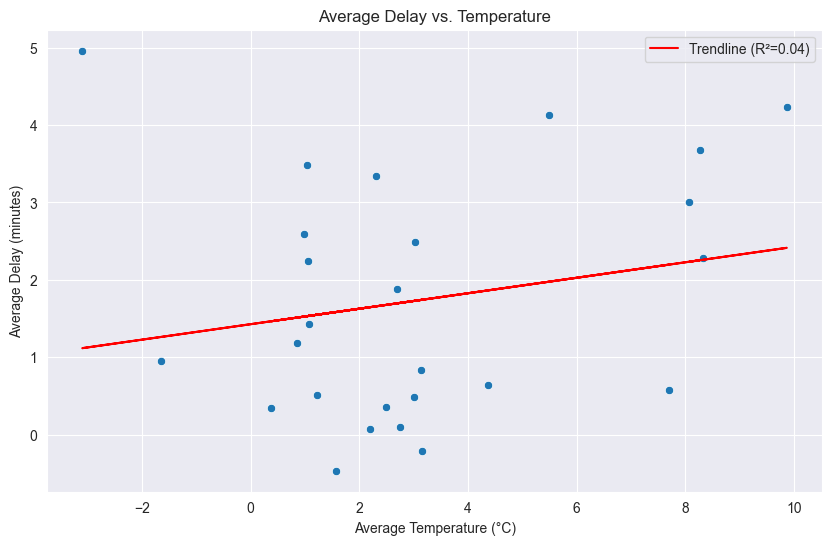

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Load the datasets
delays = pd.read_csv('data/traffic/delays-merged.csv')
weather = pd.read_csv('data/weather/weather-merged.csv')

# Convert timestamp columns to datetime
delays['timestamp'] = pd.to_datetime(delays['Timestamp'])
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

# Extract date from timestamp
delays['date'] = delays['timestamp'].dt.date
weather['date'] = weather['timestamp'].dt.date

# Calculate daily mean delay
daily_mean_delay = delays.groupby('date')['Delay'].mean()

# Calculate daily mean temperature
daily_mean_temp = weather.groupby('date')['temperatura'].mean()

# Remove outliers using IQR method
Q1 = daily_mean_delay.quantile(0.25)
Q3 = daily_mean_delay.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
daily_mean_delay = daily_mean_delay[(daily_mean_delay >= lower_bound) & (daily_mean_delay <= upper_bound)]

# Merge the daily mean delay and temperature into a single DataFrame
merged_data = pd.DataFrame({
    'mean_delay': daily_mean_delay,
    'mean_temp': daily_mean_temp
}).dropna()

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_temp', y='mean_delay', data=merged_data)
plt.title('Average Delay vs. Temperature')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Average Delay (minutes)')

# Add a trendline
slope, intercept, r_value, p_value, std_err = linregress(merged_data['mean_temp'], merged_data['mean_delay'])
plt.plot(merged_data['mean_temp'], intercept + slope * merged_data['mean_temp'], color='red',
         label=f'Trendline (R²={r_value ** 2:.2f})')
plt.legend()

plt.grid(True)
plt.show()

Wykres pokazuje słabą zależność między średnią temperaturą a średnim opóźnieniem, co potwierdza niski współczynnik \( R^2 = 0.04 \), wskazujący, że tylko 4% zmienności opóźnień można wyjaśnić temperaturą. Lekkie nachylenie linii trendu sugeruje minimalny wzrost opóźnień wraz ze wzrostem temperatury, ale dane są rozproszone, co wskazuje na brak silnej korelacji. Możliwe, że inne czynniki prawdopodobnie mają większy wpływ na opóźnienia.


### Średnie opóźnienie a suma opadów

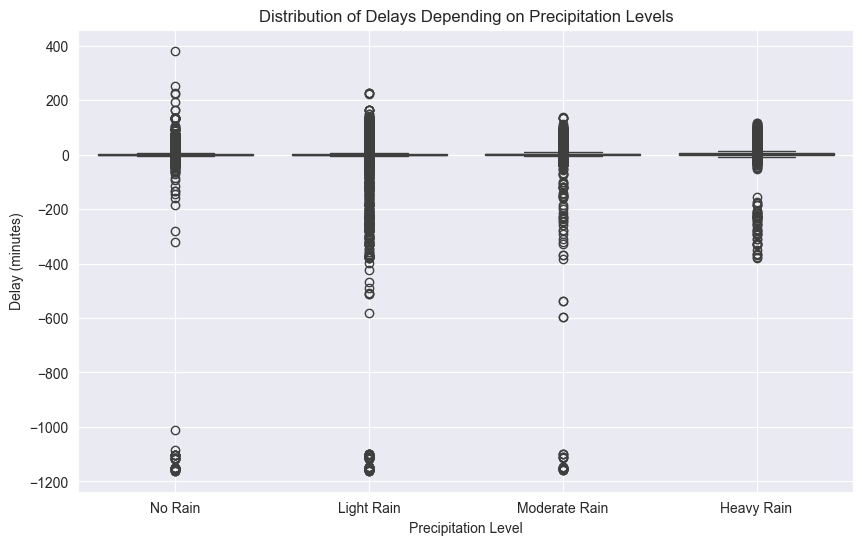

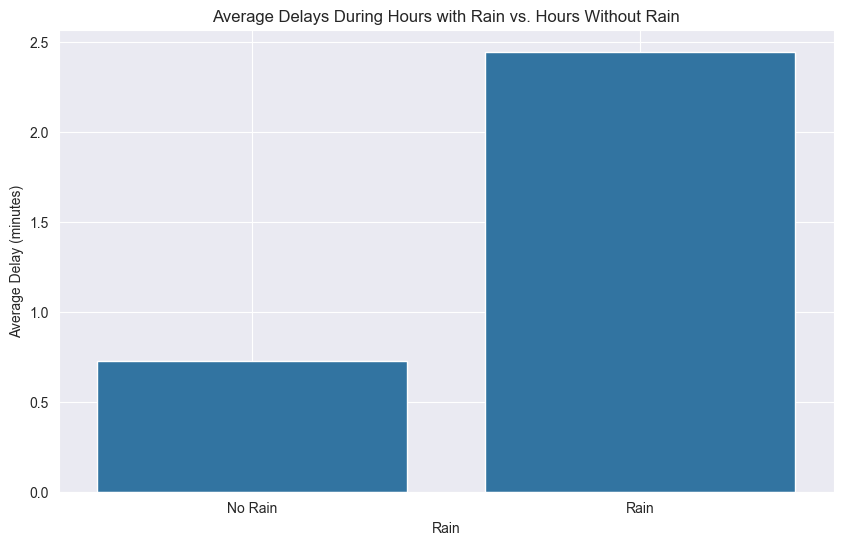

In [6]:
# Load the datasets
delays = pd.read_csv('data/traffic/delays-merged.csv')
weather = pd.read_csv('data/weather/weather-merged.csv')

# Convert timestamp columns to datetime
delays['timestamp'] = pd.to_datetime(delays['Timestamp'])
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

# Extract date and hour from timestamp
delays['date'] = delays['timestamp'].dt.date
delays['hour'] = delays['timestamp'].dt.hour
weather['date'] = weather['timestamp'].dt.date
weather['hour'] = weather['timestamp'].dt.hour

# Merge datasets on date and hour
merged_data = pd.merge(delays, weather, on=['date', 'hour'])


# Categorize precipitation levels
def categorize_precipitation(value):
    if value == 0:
        return 'No Rain'
    elif value <= 2.5:
        return 'Light Rain'
    elif value <= 7.6:
        return 'Moderate Rain'
    else:
        return 'Heavy Rain'


merged_data['precipitation_level'] = merged_data['suma_opadu'].apply(categorize_precipitation)

# Box plot: distribution of delays depending on precipitation levels
plt.figure(figsize=(10, 6))
sns.boxplot(x='precipitation_level', y='Delay', data=merged_data)
plt.title('Distribution of Delays Depending on Precipitation Levels')
plt.xlabel('Precipitation Level')
plt.ylabel('Delay (minutes)')
plt.grid(True)
plt.show()

# Bar chart: average delays during hours with rain vs. hours without rain
merged_data['rain'] = merged_data['suma_opadu'] > 0
average_delays = merged_data.groupby('rain')['Delay'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='rain', y='Delay', data=average_delays)
plt.title('Average Delays During Hours with Rain vs. Hours Without Rain')
plt.xlabel('Rain')
plt.ylabel('Average Delay (minutes)')
plt.xticks([0, 1], ['No Rain', 'Rain'])
plt.grid(True)
plt.show()

Górny wykres pokazuje rozkład opóźnień w zależności od poziomu opadów, gdzie większość wartości skupia się w okolicach 0 minut, niezależnie od intensywności deszczu, choć widoczne są skrajne wartości, takie jak duże opóźnienia czy przyspieszenia. Dolny wykres wskazuje, że średnie opóźnienia są większe podczas deszczu (około 2,5 minuty) niż w godzinach bez deszczu (około 1 minuty). Wskazuje to, że deszcz ma wpływ na opóźnienia, ale górny wykres sugeruje, że rozkład opóźnień jest szeroki i potencjalnie zależny od dodatkowych czynników.

### Średnie opóźnienie a prędkość wiatru

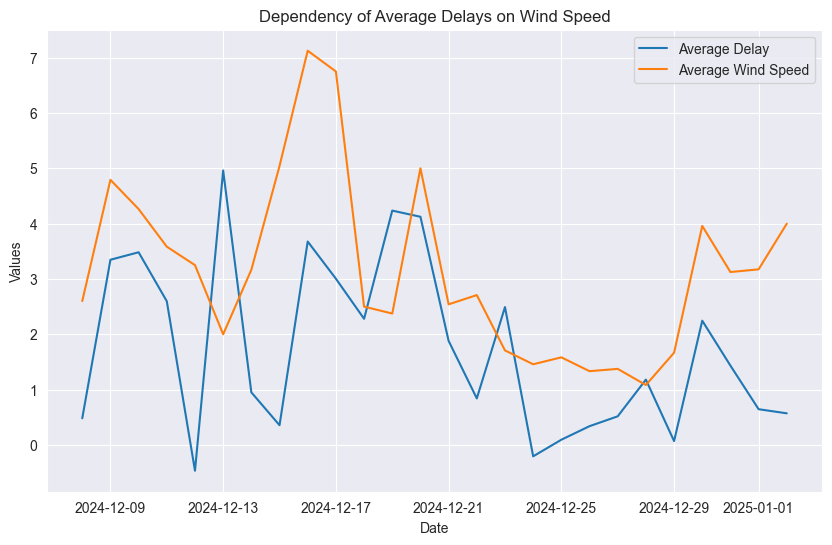

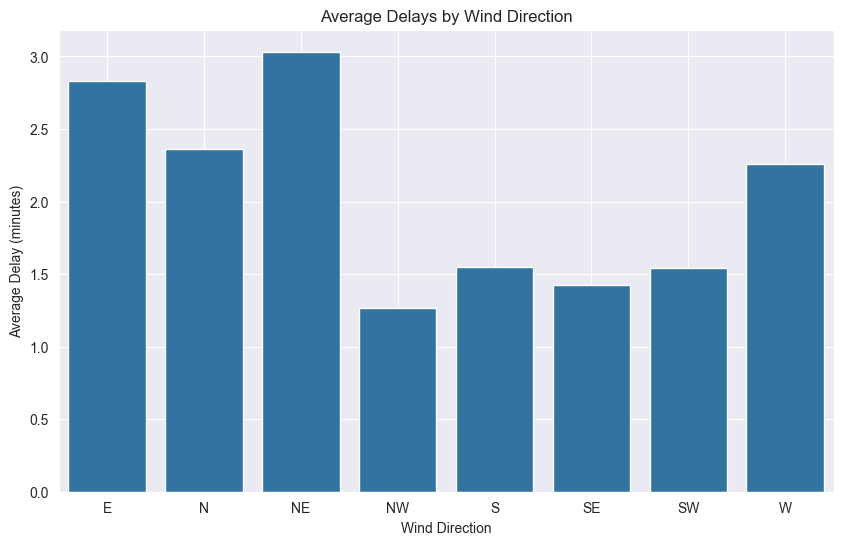

In [7]:
# Load fresh datasets
delays = pd.read_csv('data/traffic/delays-merged.csv')
weather = pd.read_csv('data/weather/weather-merged.csv')

# Convert timestamp columns to datetime
delays['timestamp'] = pd.to_datetime(delays['Timestamp'])
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

# Extract date from timestamp
delays['date'] = delays['timestamp'].dt.date
weather['date'] = weather['timestamp'].dt.date

# Calculate daily mean delay
daily_mean_delay = delays.groupby('date')['Delay'].mean()

# Remove outliers using IQR method
Q1 = daily_mean_delay.quantile(0.25)
Q3 = daily_mean_delay.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
daily_mean_delay = daily_mean_delay[(daily_mean_delay >= lower_bound) & (daily_mean_delay <= upper_bound)]

# Calculate daily mean wind speed
daily_mean_wind_speed = weather.groupby('date')['predkosc_wiatru'].mean()

# Merge the daily mean delay and wind speed into a single DataFrame
merged_data = pd.DataFrame({
    'mean_delay': daily_mean_delay,
    'mean_wind_speed': daily_mean_wind_speed
}).dropna()

# Create a line chart for the dependency of average delays on wind speed
plt.figure(figsize=(10, 6))
plt.plot(merged_data.index, merged_data['mean_delay'], label='Average Delay')
plt.plot(merged_data.index, merged_data['mean_wind_speed'], label='Average Wind Speed')
plt.title('Dependency of Average Delays on Wind Speed')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()


# Analyze the impact of wind direction on delays
# Categorize wind direction into dominant directions (N, NE, E, SE, S, SW, W, NW)
def categorize_wind_direction(degree):
    if degree >= 337.5 or degree < 22.5:
        return 'N'
    elif 22.5 <= degree < 67.5:
        return 'NE'
    elif 67.5 <= degree < 112.5:
        return 'E'
    elif 112.5 <= degree < 157.5:
        return 'SE'
    elif 157.5 <= degree < 202.5:
        return 'S'
    elif 202.5 <= degree < 247.5:
        return 'SW'
    elif 247.5 <= degree < 292.5:
        return 'W'
    else:
        return 'NW'


weather['wind_direction'] = weather['kierunek_wiatru'].apply(categorize_wind_direction)

# Merge datasets on date
merged_data = pd.merge(delays, weather, on='date')

# Calculate average delay for each wind direction
average_delay_by_wind_direction = merged_data.groupby('wind_direction')['Delay'].mean().reset_index()

# Create a bar chart for average delays by wind direction
plt.figure(figsize=(10, 6))
sns.barplot(x='wind_direction', y='Delay', data=average_delay_by_wind_direction)
plt.title('Average Delays by Wind Direction')
plt.xlabel('Wind Direction')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)
plt.show()

Górny wykres przedstawia zależność między średnimi opóźnieniami a prędkością wiatru w czasie, pokazując nieregularne zmiany obu zmiennych, bez wyraźnej korelacji między nimi. Dolny wykres pokazuje, że średnie opóźnienia różnią się w zależności od kierunku wiatru, przy czym najwyższe wartości występują przy wiatrach z kierunków NE, E i W (około 3 minuty), a najniższe przy NW (około 1,5 minuty). Wynika z tego, że prędkość wiatru ma ograniczony wpływ na opóźnienia, podczas gdy jego kierunek może mieć większe znaczenie - naturalnie, zapewne jest to korelacja pośrednia, a nie bezpośrednia. Ciężko wyobrazić sobie przypadek, w którym kierunek wiatru wprost wpływa na opóźnienia - prędzej jest to kompozycja różnych warunków pogodowych, które współwystępują z danym kierunkiem wiatru LUB jest to kierunek wiatru występujący najczęsciej w badanym okresie. Aby dokładniej przeanalizować te przypuszczenia, potrzebna będzie macierz korelacji.

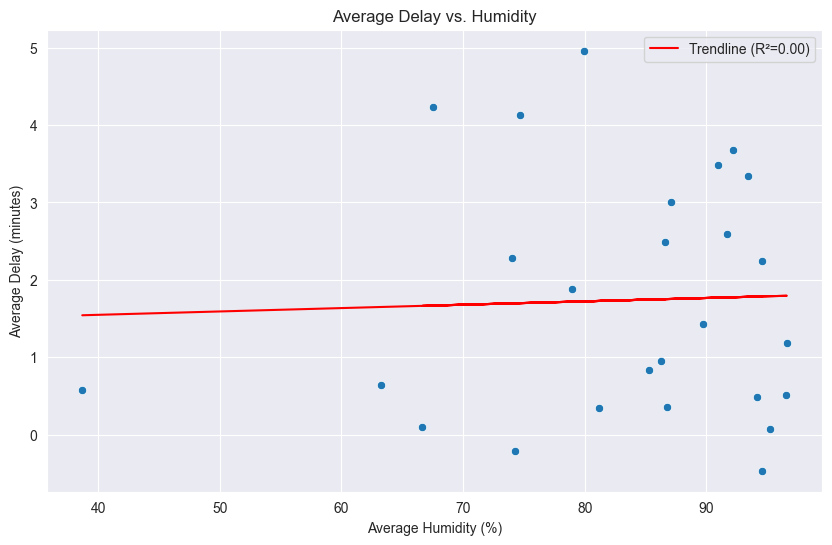

In [8]:
# Load the datasets
delays = pd.read_csv('data/traffic/delays-merged.csv')
weather = pd.read_csv('data/weather/weather-merged.csv')

# Convert timestamp columns to datetime
delays['timestamp'] = pd.to_datetime(delays['Timestamp'])
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

# Extract date from timestamp
delays['date'] = delays['timestamp'].dt.date
weather['date'] = weather['timestamp'].dt.date

# Calculate daily mean delay
daily_mean_delay = delays.groupby('date')['Delay'].mean()

# Remove outliers using IQR method
Q1 = daily_mean_delay.quantile(0.25)
Q3 = daily_mean_delay.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
daily_mean_delay = daily_mean_delay[(daily_mean_delay >= lower_bound) & (daily_mean_delay <= upper_bound)]

# Calculate daily mean humidity
daily_mean_humidity = weather.groupby('date')['wilgotnosc_wzgledna'].mean()

# Merge the daily mean delay and humidity into a single DataFrame
merged_data = pd.DataFrame({
    'mean_delay': daily_mean_delay,
    'mean_humidity': daily_mean_humidity
}).dropna()

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_humidity', y='mean_delay', data=merged_data)
plt.title('Average Delay vs. Humidity')
plt.xlabel('Average Humidity (%)')
plt.ylabel('Average Delay (minutes)')

# Add a trendline
slope, intercept, r_value, p_value, std_err = linregress(merged_data['mean_humidity'], merged_data['mean_delay'])
plt.plot(merged_data['mean_humidity'], intercept + slope * merged_data['mean_humidity'], color='red',
         label=f'Trendline (R²={r_value ** 2:.2f})')
plt.legend()

plt.grid(True)
plt.show()

Linia trendu w połączeniu z dużym rozrzutem wilgotności wskazuje zerową korelację między wilgotnością a opóźnieniami. Współczynnik determinacji \( R^2 = 0.01 \) wskazuje, że zmienności opóźnień nie można wyjaśnić wilgotnością. Warto zauważyć, że dane są rozproszone wokół linii trendu, co sugeruje brak silnej zależności między tymi dwoma zmiennymi.

## Analiza opóźnień w zależności od czasu
### Średnie opóźnienie w ciągu dnia

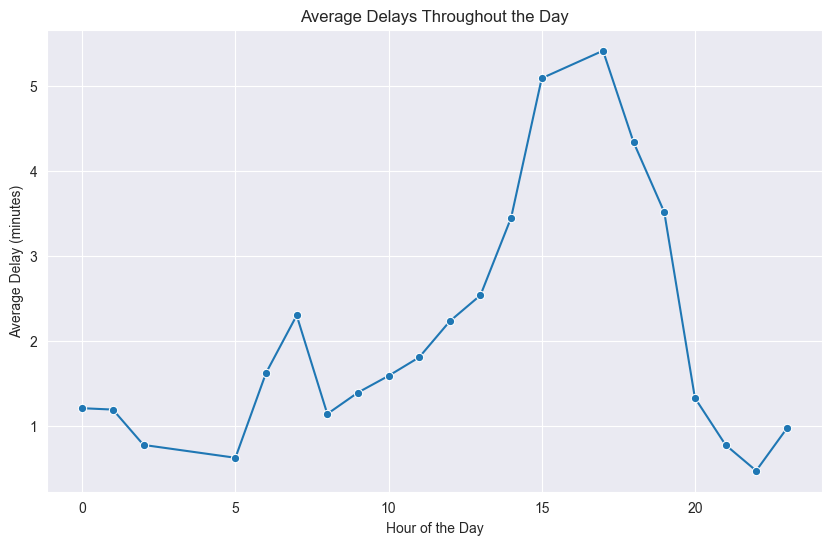

In [9]:
# Load the datasets
delays = pd.read_csv('data/traffic/delays-merged.csv')

# Convert timestamp columns to datetime
delays['timestamp'] = pd.to_datetime(delays['Timestamp'])

# Extract hour from timestamp
delays['hour'] = delays['timestamp'].dt.hour

# Calculate mean delay for each hour of the day
mean_delay_by_hour = delays.groupby('hour')['Delay'].mean().reset_index()

# Remove outliers using IQR method
Q1 = mean_delay_by_hour['Delay'].quantile(0.25)
Q3 = mean_delay_by_hour['Delay'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
mean_delay_by_hour = mean_delay_by_hour[
    (mean_delay_by_hour['Delay'] >= lower_bound) & (mean_delay_by_hour['Delay'] <= upper_bound)]

# Create a line chart for average delays broken down by hour of the day
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='Delay', data=mean_delay_by_hour, marker='o')
plt.title('Average Delays Throughout the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)
plt.show()

Wykres pokazuje, że średnie opóźnienia są największe w godzinach porannego szczytu (7-9) i popołudniowego szczytu (16-18), co sugeruje, że ruch uliczny i/lub inne czynniki mogą wpływać na opóźnienia w tych godzinach. Średnie opóźnienia są najniższe w godzinach nocnych (1-5), co może wynikać z mniejszego ruchu ulicznego w tych godzinach.

### Średnie opóźnienie w ciągu tygodnia

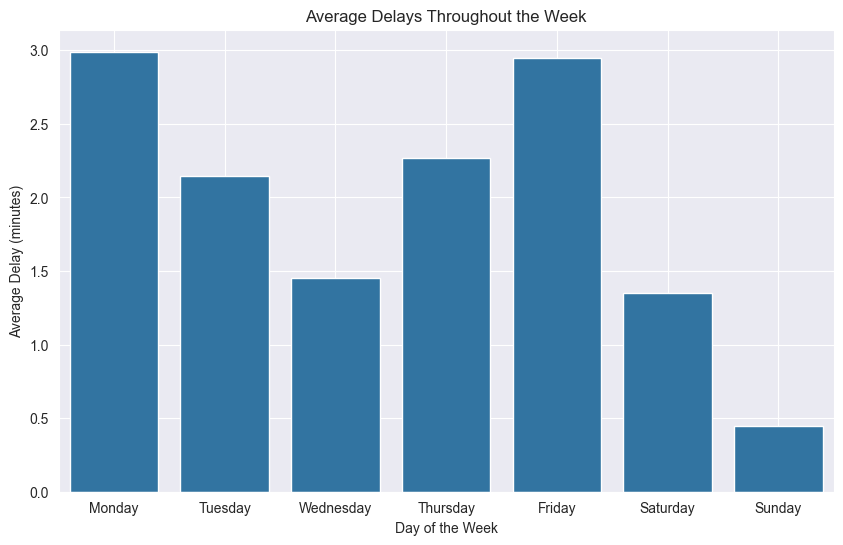

In [10]:
# Load the datasets
delays = pd.read_csv('data/traffic/delays-merged.csv')

# Convert timestamp columns to datetime
delays['timestamp'] = pd.to_datetime(delays['Timestamp'])

# Extract day of the week from timestamp
delays['day_of_week'] = delays['timestamp'].dt.day_name()

# Calculate mean delay for each day of the week
mean_delay_by_day = delays.groupby('day_of_week')['Delay'].mean().reset_index()

# Remove outliers using IQR method
Q1 = mean_delay_by_day['Delay'].quantile(0.25)
Q3 = mean_delay_by_day['Delay'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
mean_delay_by_day = mean_delay_by_day[
    (mean_delay_by_day['Delay'] >= lower_bound) & (mean_delay_by_day['Delay'] <= upper_bound)]

# Sort days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mean_delay_by_day['day_of_week'] = pd.Categorical(mean_delay_by_day['day_of_week'], categories=days_order, ordered=True)
mean_delay_by_day = mean_delay_by_day.sort_values('day_of_week')

# Create a bar chart for average delays on specific days of the week
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='Delay', data=mean_delay_by_day)
plt.title('Average Delays Throughout the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)
plt.show()

Wykres pokazuje, że średnie opóźnienia są największe w dni robocze (poniedziałek-piątek) i najniższe w weekendy (sobota-niedziela). Może to sugerować, że ruch uliczny i/lub inne czynniki wpływające na opóźnienia są bardziej intensywne w dni robocze niż w weekendy. Ciekawe jest wskazanie największych opóźnień wprost w poniedziałki oraz piatki - prawdopodobnie wiąże się to z dodatkowymi czynnikami występującymi w te dni - być może jak powrót do pracy po weekendzie lub chęć szybkiego powrotu do domu. Warto zauważyć, że średnie opóźnienia w soboty są wyższe niż w niedziele, co może wynikać z większej aktywności w soboty niż w niedziele.

### Analiza opóźnień w ciągu miesiąca

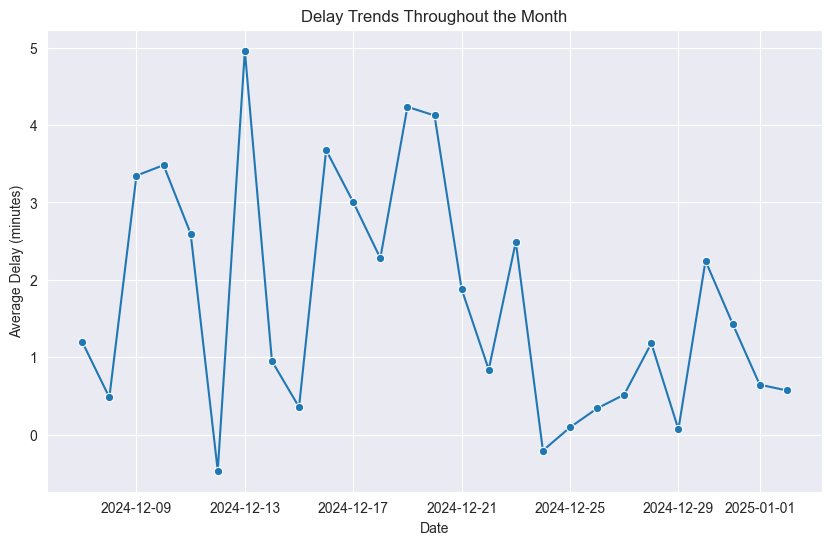

In [11]:
# Load the datasets
delays = pd.read_csv('data/traffic/delays-merged.csv')

# Convert timestamp columns to datetime
delays['timestamp'] = pd.to_datetime(delays['Timestamp'])

# Extract date from timestamp
delays['date'] = delays['timestamp'].dt.date

# Calculate mean delay for each day of the month
mean_delay_by_day = delays.groupby('date')['Delay'].mean().reset_index()

# Remove outliers using IQR method
Q1 = mean_delay_by_day['Delay'].quantile(0.25)
Q3 = mean_delay_by_day['Delay'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
mean_delay_by_day = mean_delay_by_day[
    (mean_delay_by_day['Delay'] >= lower_bound) & (mean_delay_by_day['Delay'] <= upper_bound)]

# Create a line chart for delay trends throughout the month
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='Delay', data=mean_delay_by_day, marker='o')
plt.title('Delay Trends Throughout the Month')
plt.xlabel('Date')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)
plt.show()

Wykres pokazuje, że średnie opóźnienia są zróżnicowane w ciągu miesiąca, z wyraźnymi wzrostami i spadkami w różnych dniach. Może to sugerować, że opóźnienia są bardziej zróżnicowane w różnych dniach miesiąca, co może wynikać z różnych warunków pogodowych, ruchu ulicznego i/lub innych czynników wpływających na opóźnienia. Ciekawą obserwacją jest wyraźny spadek opóźnień po 22 grudnia, co może wynikać z mniejszego ruchu ulicznego w okresie świątecznym.

## Analiza opóźnień w zależności od linii / typu pojazdu
### Średnie opóźnienie w zależności od typu pojazdu

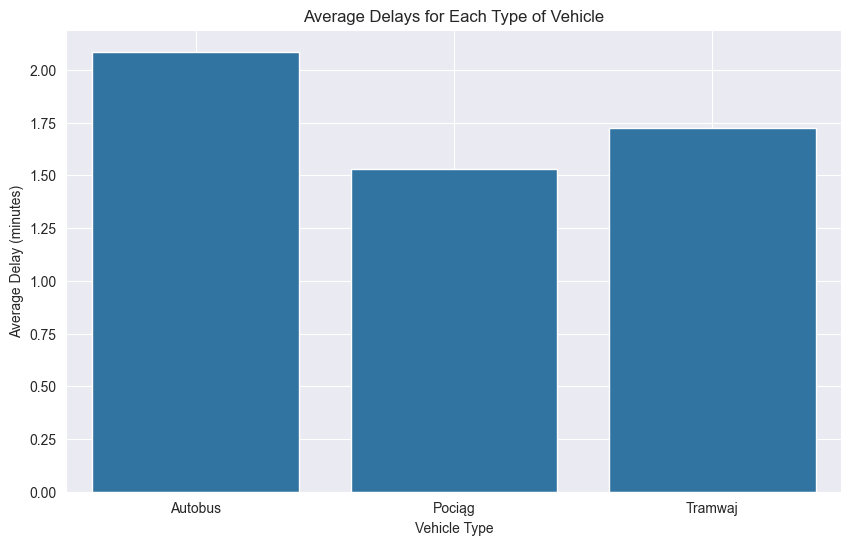

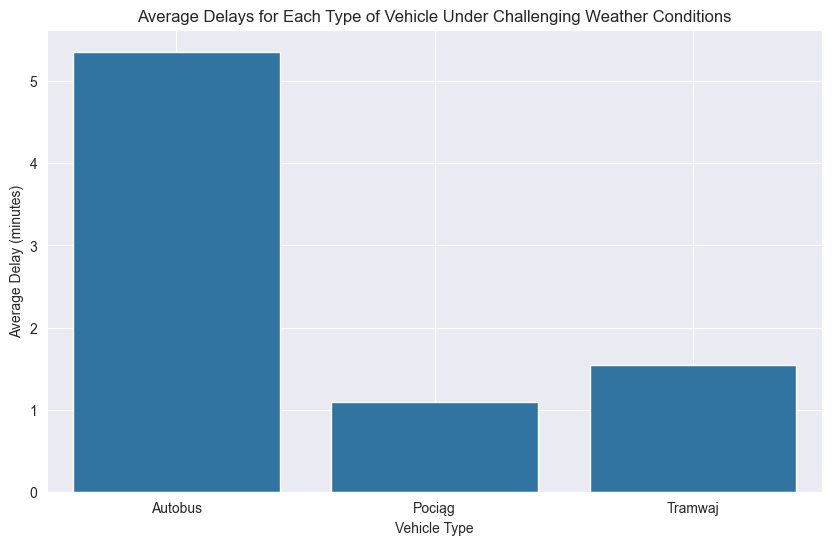

In [12]:
# Load the datasets
delays = pd.read_csv('data/traffic/delays-merged.csv')
weather = pd.read_csv('data/weather/weather-merged.csv')

# Convert timestamp columns to datetime
delays['timestamp'] = pd.to_datetime(delays['Timestamp'])
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

# Extract vehicle type from the data
delays['vehicle_type'] = delays['Type']

# Calculate mean delay for each vehicle type
mean_delay_by_vehicle = delays.groupby('vehicle_type')['Delay'].mean().reset_index()

# Remove outliers using IQR method
Q1 = mean_delay_by_vehicle['Delay'].quantile(0.25)
Q3 = mean_delay_by_vehicle['Delay'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
mean_delay_by_vehicle = mean_delay_by_vehicle[
    (mean_delay_by_vehicle['Delay'] >= lower_bound) & (mean_delay_by_vehicle['Delay'] <= upper_bound)]

# Create a bar chart for average delays for each type of vehicle
plt.figure(figsize=(10, 6))
sns.barplot(x='vehicle_type', y='Delay', data=mean_delay_by_vehicle)
plt.title('Average Delays for Each Type of Vehicle')
plt.xlabel('Vehicle Type')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)
plt.show()

# Perform a comparative analysis of delays under challenging weather conditions
# Merge datasets on date and hour
delays['date'] = delays['timestamp'].dt.date
delays['hour'] = delays['timestamp'].dt.hour
weather['date'] = weather['timestamp'].dt.date
weather['hour'] = weather['timestamp'].dt.hour
merged_data = pd.merge(delays, weather, on=['date', 'hour'])

# Define challenging weather conditions (e.g., heavy rain, high wind speed)
challenging_conditions = (merged_data['suma_opadu'] > 7.6) | (merged_data['predkosc_wiatru'] > 15)

# Calculate mean delay for each vehicle type under challenging conditions
mean_delay_challenging = merged_data[challenging_conditions].groupby('vehicle_type')['Delay'].mean().reset_index()

# Create a bar chart for average delays under challenging weather conditions
plt.figure(figsize=(10, 6))
sns.barplot(x='vehicle_type', y='Delay', data=mean_delay_challenging)
plt.title('Average Delays for Each Type of Vehicle Under Challenging Weather Conditions')
plt.xlabel('Vehicle Type')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)
plt.show()

Górny wykres pokazuje, że najbardziej spóźniającym się typem pojazdów są autobusy, a najmniej - pociągi WKD. Pośrednim środkiem transportu są tramwaje. Dolny wykres pokazuje, że opóźnienia są największe dla autobusów podczas trudnych warunków pogodowych, co sugeruje, że autobusy są bardziej podatne na opóźnienia w trudnych warunkach pogodowych niż inne typy pojazdów.

### Średnie opóźnienie w zależności od linii lub brygady

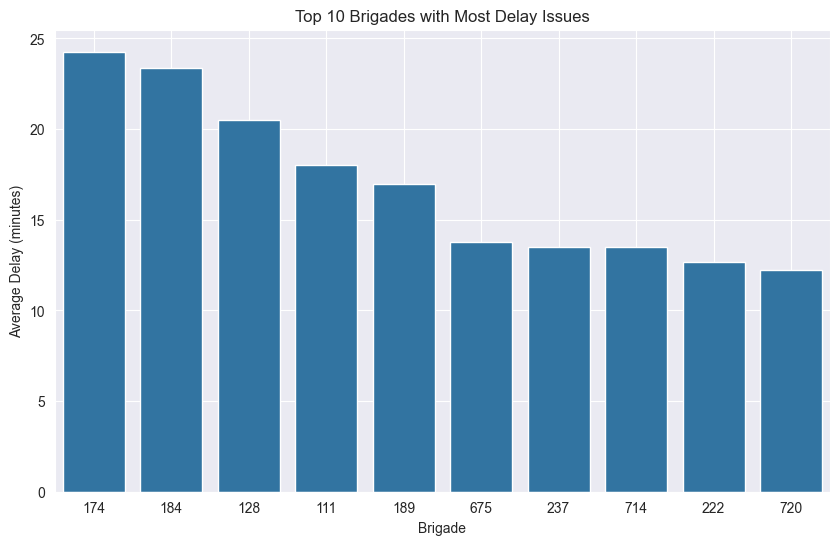

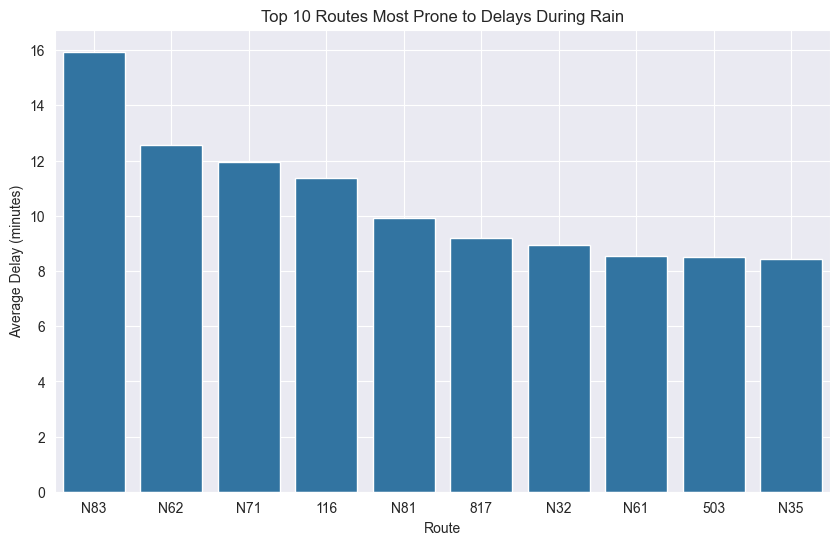

In [13]:
# Load the datasets
delays = pd.read_csv('data/traffic/delays-merged.csv')
weather = pd.read_csv('data/weather/weather-merged.csv')

# Convert timestamp columns to datetime
delays['timestamp'] = pd.to_datetime(delays['Timestamp'])
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

# Extract brigade and route information
delays['brigade'] = delays['Brigade']
delays['route'] = delays['Route']

# Calculate mean delay for each brigade
mean_delay_by_brigade = delays.groupby('brigade')['Delay'].mean().reset_index()

# Identify brigades with the most delay issues
most_delayed_brigades = mean_delay_by_brigade.sort_values(by='Delay', ascending=False).head(10)

# Plot brigades with the most delay issues
plt.figure(figsize=(10, 6))
sns.barplot(x='brigade', y='Delay', data=most_delayed_brigades)
plt.title('Top 10 Brigades with Most Delay Issues')
plt.xlabel('Brigade')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)
plt.show()

# Merge datasets on date and hour
delays['date'] = delays['timestamp'].dt.date
delays['hour'] = delays['timestamp'].dt.hour
weather['date'] = weather['timestamp'].dt.date
weather['hour'] = weather['timestamp'].dt.hour
merged_data = pd.merge(delays, weather, on=['date', 'hour'])

# Define rain condition
rain_condition = merged_data['suma_opadu'] > 0

# Calculate mean delay for each route during rain
mean_delay_by_route_rain = merged_data[rain_condition].groupby('route')['Delay'].mean().reset_index()

# Identify routes most prone to delays during rain
most_delayed_routes_rain = mean_delay_by_route_rain.sort_values(by='Delay', ascending=False).head(10)

# Plot routes most prone to delays during rain
plt.figure(figsize=(10, 6))
sns.barplot(x='route', y='Delay', data=most_delayed_routes_rain)
plt.title('Top 10 Routes Most Prone to Delays During Rain')
plt.xlabel('Route')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)
plt.show()

Górny wykres pokazuje, że najbardziej spóźniającą się brygadą jest brygada 174. Warto mieć na uwadze, że jest to jedna ze standardowych brygad, uruchamianych rutynowo, wg. definicji brygad ZTM. Może to sugerować nadmierne obłożenie członków realizujących połączenie przeznaczone danej brygadzie - lub przypisanie im najbardziej problematycznych linii. Dolny wykres pokazuje, że najbardziej skłonnymi do opoźnienia liniami w trakcie deszczu są linie nocne - N83, N62, N71. Jest to dziwne, gdyż zazwyczaj takie linie nie operują w skomplikowanych warunkach ruchu.

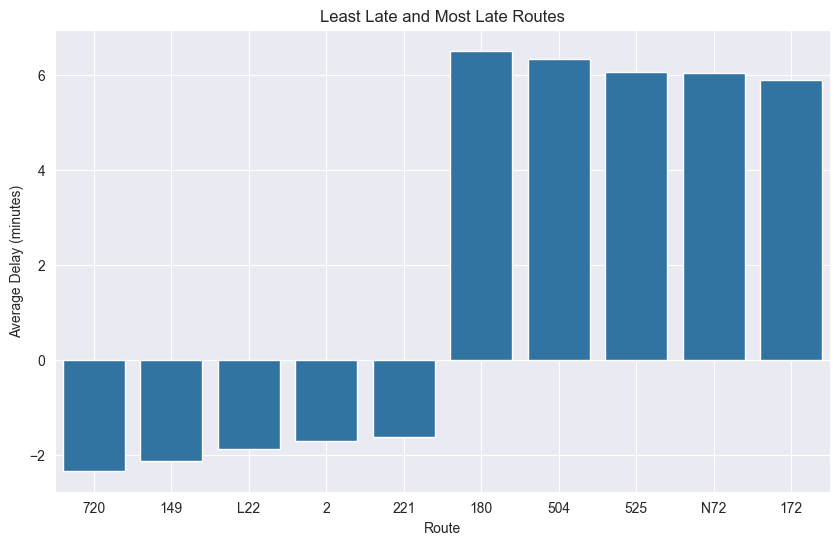

In [14]:
# Load the dataset
delays = pd.read_csv('data/traffic/delays-merged.csv')

# Convert timestamp columns to datetime
delays['timestamp'] = pd.to_datetime(delays['Timestamp'])

# Extract route information
delays['route'] = delays['Route']

# Calculate mean delay for each route
mean_delay_by_route = delays.groupby('route')['Delay'].mean().reset_index()

# Remove outliers using IQR method
Q1 = mean_delay_by_route['Delay'].quantile(0.25)
Q3 = mean_delay_by_route['Delay'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
mean_delay_by_route = mean_delay_by_route[
    (mean_delay_by_route['Delay'] >= lower_bound) & (mean_delay_by_route['Delay'] <= upper_bound)]

# Identify the least late and most late routes
least_late_routes = mean_delay_by_route.nsmallest(5, 'Delay')
most_late_routes = mean_delay_by_route.nlargest(5, 'Delay')

# Combine the least late and most late routes
combined_routes = pd.concat([least_late_routes, most_late_routes])

# Create a bar chart for the least late and most late routes
plt.figure(figsize=(10, 6))
sns.barplot(x='route', y='Delay', data=combined_routes)
plt.title('Least Late and Most Late Routes')
plt.xlabel('Route')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)
plt.show()

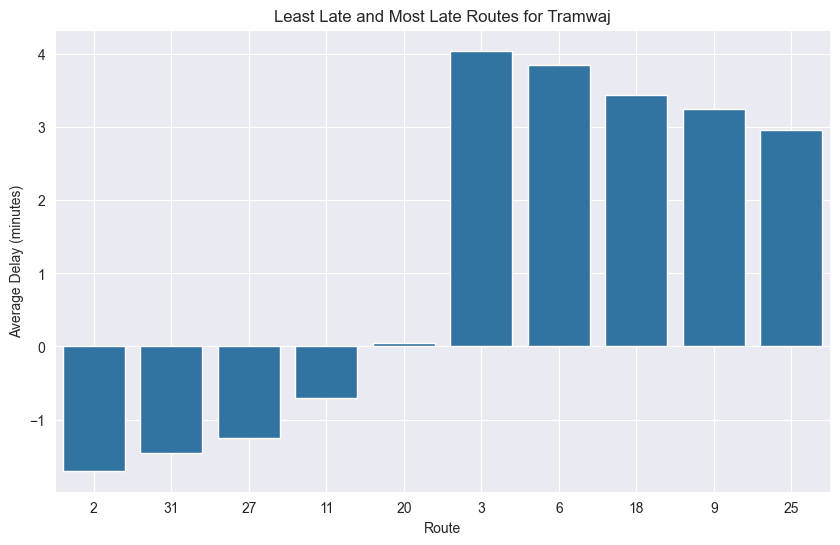

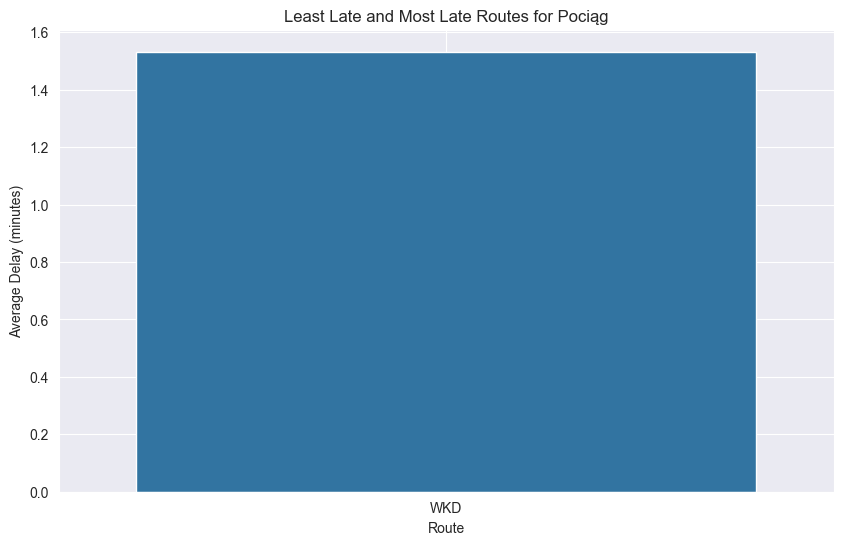

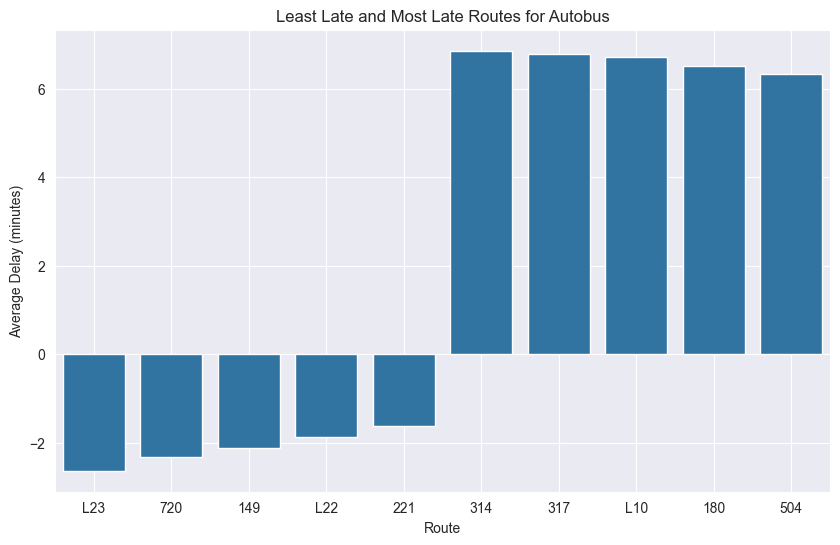

In [15]:
# Load the datasets
delays = pd.read_csv('data/traffic/delays-merged.csv')
weather = pd.read_csv('data/weather/weather-merged.csv')

# Convert timestamp columns to datetime
delays['timestamp'] = pd.to_datetime(delays['Timestamp'])
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

# Extract route and vehicle type information
delays['route'] = delays['Route']
delays['vehicle_type'] = delays['Type']


# Function to create graphs for a specific vehicle type
def create_graphs(vehicle_type):
    # Filter data by vehicle type
    vehicle_delays = delays[delays['vehicle_type'] == vehicle_type]

    # Calculate mean delay for each route
    mean_delay_by_route = vehicle_delays.groupby('route')['Delay'].mean().reset_index()

    # Remove outliers using IQR method
    Q1 = mean_delay_by_route['Delay'].quantile(0.25)
    Q3 = mean_delay_by_route['Delay'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mean_delay_by_route = mean_delay_by_route[
        (mean_delay_by_route['Delay'] >= lower_bound) & (mean_delay_by_route['Delay'] <= upper_bound)]

    # Identify the least late and most late routes
    least_late_routes = mean_delay_by_route.nsmallest(5, 'Delay')
    most_late_routes = mean_delay_by_route.nlargest(5, 'Delay')

    # Combine the least late and most late routes
    combined_routes = pd.concat([least_late_routes, most_late_routes])

    # Create a bar chart for the least late and most late routes
    plt.figure(figsize=(10, 6))
    sns.barplot(x='route', y='Delay', data=combined_routes)
    plt.title(f'Least Late and Most Late Routes for {vehicle_type}')
    plt.xlabel('Route')
    plt.ylabel('Average Delay (minutes)')
    plt.grid(True)
    plt.show()


# Create graphs for each vehicle type
create_graphs('Tramwaj')
create_graphs('Pociąg')
create_graphs('Autobus')

# Mapa opóźnień

In [16]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Load the datasets
delays = pd.read_csv('data/traffic/delays-merged.csv')
stops = pd.read_csv('data/gtfs/2025/01/03/stops.csv')

# Convert timestamp columns to datetime
delays['timestamp'] = pd.to_datetime(delays['Timestamp'])

# Extract stop information
delays['stop_name'] = delays['Stop Name']

# Merge delays with stop locations by stop_name
delays_with_stops = pd.merge(delays, stops, left_on='stop_name', right_on='stop_name')

# Calculate mean delay for each stop
mean_delay_by_stop = delays_with_stops.groupby(['stop_name', 'stop_lat', 'stop_lon'])['Delay'].mean().reset_index()

# Remove outliers using IQR method
Q1 = mean_delay_by_stop['Delay'].quantile(0.25)
Q3 = mean_delay_by_stop['Delay'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
mean_delay_by_stop = mean_delay_by_stop[
    (mean_delay_by_stop['Delay'] >= lower_bound) & (mean_delay_by_stop['Delay'] <= upper_bound)]

# Create a map centered on Warsaw
warsaw_map = folium.Map(location=[52.2297, 21.0122], zoom_start=12)

# Add a heatmap layer to the map
heat_data = [[row['stop_lat'], row['stop_lon'], row['Delay']] for index, row in mean_delay_by_stop.iterrows()]
HeatMap(heat_data).add_to(warsaw_map)

# Save the map to an HTML file
warsaw_map.save('warsaw_delays_map.html')

In [17]:
# Load the datasets
delays = pd.read_csv('data/traffic/delays-merged.csv')
stops = pd.read_csv('data/gtfs/2025/01/03/stops.csv')

# Convert timestamp columns to datetime
delays['timestamp'] = pd.to_datetime(delays['Timestamp'])

# Extract stop and vehicle type information
delays['stop_name'] = delays['Stop Name']
delays['vehicle_type'] = delays['Type']

# Merge delays with stop locations by stop_name
delays_with_stops = pd.merge(delays, stops, left_on='stop_name', right_on='stop_name')


# Function to create a heatmap for a specific vehicle type
def create_heatmap(vehicle_type, map_filename):
    # Filter data by vehicle type
    vehicle_delays = delays_with_stops[delays_with_stops['vehicle_type'] == vehicle_type]

    # Calculate mean delay for each stop
    mean_delay_by_stop = vehicle_delays.groupby(['stop_name', 'stop_lat', 'stop_lon'])['Delay'].mean().reset_index()

    # Remove outliers using IQR method
    Q1 = mean_delay_by_stop['Delay'].quantile(0.25)
    Q3 = mean_delay_by_stop['Delay'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mean_delay_by_stop = mean_delay_by_stop[
        (mean_delay_by_stop['Delay'] >= lower_bound) & (mean_delay_by_stop['Delay'] <= upper_bound)]

    # Create a map centered on Warsaw
    warsaw_map = folium.Map(location=[52.2297, 21.0122], zoom_start=12)

    # Add a heatmap layer to the map
    heat_data = [[row['stop_lat'], row['stop_lon'], row['Delay']] for index, row in mean_delay_by_stop.iterrows()]
    HeatMap(heat_data).add_to(warsaw_map)

    # Save the map to an HTML file
    warsaw_map.save(map_filename)


# Create heatmaps for buses and trams
create_heatmap('Autobus', 'warsaw_bus_delays_map.html')
create_heatmap('Tramwaj', 'warsaw_tram_delays_map.html')

Na mapach cieplnych bardzo widoczne są trasy tramwajów oraz autobusów, sięgające w różne strefy Warszawy. Gdy przybliży się mapę, można zauważyć, że największe opóźnienia występują w centrum miasta, co jest zgodne z oczekiwaniami, biorąc pod uwagę zatłoczenie ulic i skrzyżowań w tej części miasta. Warto zauważyć, że opóźnienia są bardziej skoncentrowane wokół centrów przesiadkowych, co sugeruje, że ruch uliczny i/lub inne czynniki wpływające na opóźnienia są bardziej intensywne w tych obszarach.